In [1]:
# Setup
from notebook_utils import resolve_paths_from_parent_directory

# auto reload notebook deps
%reload_ext autoreload
%autoreload 2
resolve_paths_from_parent_directory()

In [109]:
import torch
import torch.optim as optim
from utils import (
    split_img, 
    ToPILImage, 
    ToTensor
)
from objective import (
    LG_c,
    LG_x,
    LG_y,
    LRec,
    LOrth,
    LCyc,
)
from tqdm import tqdm
from train import train
from model import SupUCA
from dataset import MNISTHalves
from torchvision import datasets
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

In [3]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load training data
train_dataset = datasets.MNIST(root='../data/', train=True, download=True)
train_x = []
train_y = []

for i in tqdm(range(train_dataset.data.shape[0])):
    img = ToPILImage(train_dataset.data[i])
    x, y = split_img(img)
    train_x.append(ToTensor(x))
    train_y.append(ToTensor(y))

train_x = torch.stack(train_x)
train_y = torch.stack(train_y)

# load test data
test_dataset = datasets.MNIST(root='../data/', train=False, download=True)
test_x = []
test_y = []

for i in tqdm(range(test_dataset.data.shape[0])):
    img = ToPILImage(test_dataset.data[i])
    x, y = split_img(img)
    test_x.append(ToTensor(x))
    test_y.append(ToTensor(y))

test_x = torch.stack(test_x)
test_y = torch.stack(test_y)

# build datasets / data loaders
batch_size = 128
train_data = MNISTHalves(train_x, train_y)
test_data = MNISTHalves(test_x, test_y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 10000/10000 [00:13<00:00, 724.21it/s]


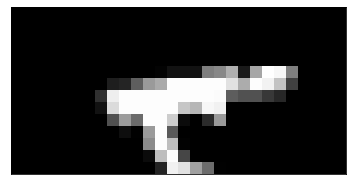

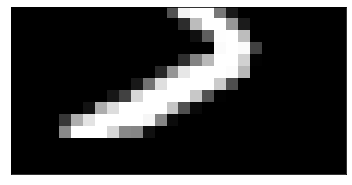

In [4]:
x, y = split_img(ToPILImage(train_dataset.data[0]))

plt.imshow(x, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(y, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
print(ToTensor(x).shape)
print(ToTensor(y).shape)

torch.Size([1, 14, 28])
torch.Size([1, 14, 28])


In [188]:
# build model
model = SupUCA()
model.to(device)

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

In [189]:
model = train(model, optimizer, train_loader, test_loader, device, epochs=50)

epoch: 0 | train: 0.004 | test: 0.002
epoch: 1 | train: 0.002 | test: 0.002
epoch: 2 | train: 0.002 | test: 0.002
epoch: 3 | train: 0.002 | test: 0.002
epoch: 4 | train: 0.002 | test: 0.002
epoch: 5 | train: 0.002 | test: 0.002
epoch: 6 | train: 0.002 | test: 0.002
epoch: 7 | train: 0.002 | test: 0.002
epoch: 8 | train: 0.002 | test: 0.002
epoch: 9 | train: 0.002 | test: 0.002
epoch: 10 | train: 0.002 | test: 0.002
epoch: 11 | train: 0.002 | test: 0.002
epoch: 12 | train: 0.002 | test: 0.002
epoch: 13 | train: 0.002 | test: 0.002
epoch: 14 | train: 0.002 | test: 0.002
epoch: 15 | train: 0.002 | test: 0.002
epoch: 16 | train: 0.002 | test: 0.002
epoch: 17 | train: 0.002 | test: 0.002
epoch: 18 | train: 0.002 | test: 0.002
epoch: 19 | train: 0.002 | test: 0.002
epoch: 20 | train: 0.002 | test: 0.002
epoch: 21 | train: 0.002 | test: 0.002
epoch: 22 | train: 0.002 | test: 0.002
epoch: 23 | train: 0.002 | test: 0.002
epoch: 24 | train: 0.002 | test: 0.002
epoch: 25 | train: 0.002 | test: 0.

In [138]:
model

SupUCA(
  (W_x): Linear(in_features=392, out_features=10, bias=False)
  (W_y): Linear(in_features=392, out_features=10, bias=False)
  (V_x): Linear(in_features=10, out_features=392, bias=False)
  (V_y): Linear(in_features=10, out_features=392, bias=False)
)

In [150]:
model.W_x.weight.shape

torch.Size([10, 392])

In [ ]:
# 0 0.05536247044801712 0.1000412330031395 0.10698886960744858 0.20268896222114563 407.3427734375 0.18819642066955566
# 1 0.0581776425242424 0.10206615924835205 0.107453353703022 0.20503103733062744 472.56683349609375 0.1909014880657196
# 2 0.047054268419742584 0.09922389686107635 0.10572079569101334 0.20069904625415802 275.2247619628906 0.18823207914829254
# 3 0.04529514163732529 0.10040970891714096 0.10588136315345764 0.20227110385894775 272.14764404296875 0.19133839011192322
# 4 0.04091145843267441 0.09923728555440903 0.10818449407815933 0.20469573140144348 203.96575927734375 0.19244319200515747

In [92]:
import numpy as np

In [93]:
A = np.array([[2, -2, 1], [1, 2, 2], [2, 1, -2]])
A = A / 3

In [94]:
A = torch.from_numpy(A)

In [95]:
A

tensor([[ 0.6667, -0.6667,  0.3333],
        [ 0.3333,  0.6667,  0.6667],
        [ 0.6667,  0.3333, -0.6667]], dtype=torch.float64)

In [96]:
LOrth(A, A)

tensor(4.9452e-66, dtype=torch.float64)

In [190]:
top = train_data[0][0]
bottom = train_data[0][1]


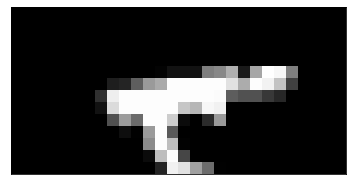

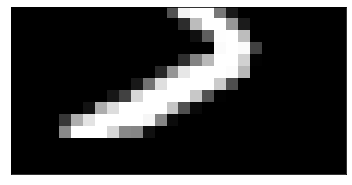

In [191]:
top = top.reshape(14, 28)
top = top - top.mean()
plt.imshow(top, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

bottom = bottom.reshape(14, 28)
bottom = bottom - bottom.mean()
plt.imshow(bottom, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

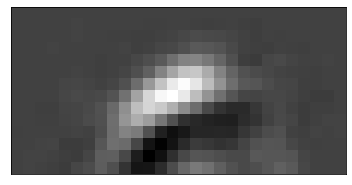

In [192]:
test_img = train_data[0][1].reshape(1, 14 * 28)
test_img = test_img - test_img.mean()
test_img = test_img @ model.W_x.weight.t()
test_img = test_img @ model.V_x.weight.t()
test_img = test_img.reshape(14, 28).detach().numpy()
plt.imshow(test_img, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()